## Work
1. 試比較 save_best_only 與否的差異
2. 請僅存入將 save_weights_only 設定為 True, 並嘗試 reset ipynb 並將模型與權重重新建回並預測 x_test

In [0]:
import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [0]:
train, test = keras.datasets.cifar10.load_data()

In [0]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [0]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [0]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                  activation="relu",
                                  name=f"hidden_layer{str(i+1)}")(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                  activation="relu",
                                  name=f"hidden_layer{str(i+1)}")(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units,
                               activation="softmax",
                               name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [0]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [16]:
# 載入 Callbacks
"""Code Here
設定 callbacks: model checkpoint
"""
from keras.callbacks import ModelCheckpoint



results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for s in ["only", "not_only"]:
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    if s == "only":
        model_ckpt = ModelCheckpoint(filepath=f"./{s}.h5",
                                monitor="val_loss",
                                save_best_only=True)
    else:
        model_ckpt = ModelCheckpoint(filepath=f"./{s}.h5",
                                monitor="val_loss",
                                save_best_only=False)

# 沒寫進去, 只儲存參數, 要用load_weights使用。
#     model_ckpt = ModelCheckpoint(filepath="./tmp.h5", 
#                              monitor="val_loss", 
#                              save_best_only=save_best,
#                              save_weights_only=True)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[model_ckpt]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    results[s] = {'train-loss': train_loss,
                 'valid-loss': valid_loss,
                 'train-acc': train_acc,
                 'valid-acc': valid_acc}

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128)               512 

10000/10000 [==============================] - 2s 171us/step


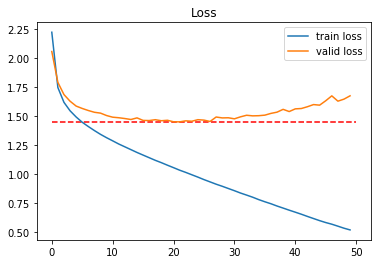

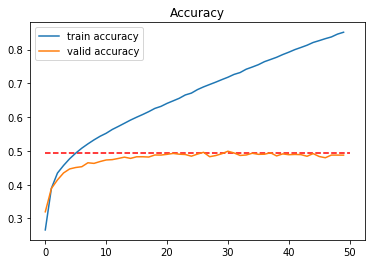

10000/10000 [==============================] - 2s 162us/step


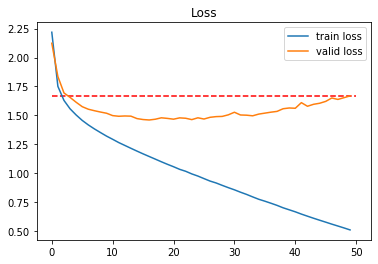

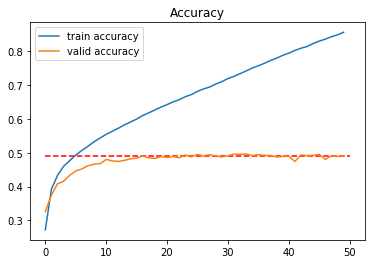

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
# color_bar = ["r", "g", "b", "y", "m", "k"]

# plt.figure(figsize=(8,6))
# for i, cond in enumerate(results.keys()):
#     plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
#     plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
# plt.title("Loss")
# plt.legend()
# plt.show()

# plt.figure(figsize=(8,6))
# for i, cond in enumerate(results.keys()):
#     plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
#     plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
# plt.title("Accuracy")
# plt.legend()
# plt.show()

for s in ["only", "not_only"]:
    # Load back
    model = keras.models.load_model(f"./{s}.h5")
    loss_loadback, acc_loadback = model.evaluate(x_test, y_test)

    plt.plot(range(len(results[s]['train-loss'])), results[s]['train-loss'], label="train loss")
    plt.plot(range(len(results[s]['valid-loss'])), results[s]['valid-loss'], label="valid loss")
    plt.hlines(y=loss_loadback, xmin=0, xmax=len(results[s]['train-loss']), colors='r', linestyles='--')
    plt.legend()
    plt.title("Loss")
    plt.show()

    plt.plot(range(len(results[s]['train-acc'])), results[s]['train-acc'], label="train accuracy")
    plt.plot(range(len(results[s]['valid-acc'])), results[s]['valid-acc'], label="valid accuracy")
    plt.hlines(y=acc_loadback, xmin=0, xmax=len(results[s]['train-acc']), colors='r', linestyles='--')
    plt.legend()
    plt.title("Accuracy")
    plt.show()